## Step 1. Pick three different Ranking Metrics

I decided to pick Precision@k, Recall@k and Reciprocal Rank. Precision@k and Recall@k were chosen because they sounded the most familiar and calming, RR was in my head since the lecture because word Reciprocal is hard to read and pronounce.

## Step 2. Generate search results using one of random distributions as argument for the function

In order to understand, what exactly should be presented as search results, I turned to kaggle datasets and checked which fields they usually contain. The list was: search terms, rank, title, snippet, display link, link, query time, total results, cache id. Due to the tasks specifics, i dropped most of the fields, and left title, snippet and link. Rank in my representation is corresponding to the place in the list ([0] element - 1 rank)\
To fill in the fields i used https://medium.com/@mohamedmeqlad9/faker-the-perfect-python-package-to-generate-fake-data-6f43fa168e86 and also took the idea of titles here https://stackoverflow.com/questions/59110057/how-to-use-faker-to-generate-titles-and-real-english-texts \
Comments to if conditions are in the code directly

In [ ]:
!pip install Faker

In [ ]:
from dataclasses import dataclass
from typing import List, Callable
from faker import Faker
import numpy as np

@dataclass
class SearchResult:
    title: str
    link: str
    snippet: str
    relevance: float

def generate_and_distribute(distribution_func: Callable[[int], float], n: int = 20) -> List[SearchResult]:
    search_results = []
    checks = []
    fake = Faker()

    for i in range(n):
        title = fake.name() + " " + fake.company()
        link = fake.url()
        snippet = fake.text()
        relevance = distribution_func(i)
        rank = i+1

        result = SearchResult(title=title, link=link, snippet=snippet, relevance=relevance)
        search_results.append(result)
        checks.append(relevance)

# This if's are used to represent the data that was generated. For each distribution (step 4) the graph is plotted,
# to see the data appearance. Also distributions are checked to follow tests
# I used it to make sure, that my generation fits and just check my own actions. I know that tests might not be enough to
# confidently state that data follows distribution, for me it was just a small reassurance

    if distribution_func == normal_distribution:
      plt.hist(checks, bins=10, density=True, alpha=0.6, color='g')
      plt.xlabel('Relevance')

      mu, std = np.mean(checks), np.std(checks)
      xmin, xmax = plt.xlim()
      x = np.linspace(xmin, xmax, 100)
      p = norm.pdf(x, mu, std)
      plt.plot(x, p, 'k', linewidth=2)
      plt.show()

      stat, p = shapiro(checks)
      if p > 0.05:
          print('Follows normal distribution (Shapiro-Wilk)')
      else:
          print('Data failed (Shapiro-Wilk)')

      stat, p = kstest(checks, 'norm', args=(mu, std))
      if p > 0.05:
          print('Follows normal distribution (Kolmogorov-Smirnov)')
      else:
          print('Data failed (Kolmogorov-Smirnov)')

    elif distribution_func == cauchy_distribution:
        plt.hist(checks, bins=10, density=True, alpha=0.6, color='b')
        plt.xlabel('Relevance')

        loc, scale = np.median(checks), np.percentile(checks, 75) - np.percentile(checks, 25)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = cauchy.pdf(x, loc, scale)
        plt.plot(x, p, 'k', linewidth=2)
        plt.title('Cauchy Distribution')
        plt.show()

        stat, p = kstest(checks, 'cauchy', args=(loc, scale))
        if p > 0.05:
            print('Data follows cauchy distribution (Kolmogorov-Smirnov)')
        else:
            print('Data failed (Kolmogorov-Smirnov)')

    elif distribution_func == beta_distribution:
        plt.hist(checks, bins=10, density=True, alpha=0.6, color='r')
        plt.xlabel('Relevance')

        a, b = 2.0, 2.0
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = beta.pdf(x, a, b)
        plt.plot(x, p, 'k', linewidth=2)
        plt.title('Beta Distribution')
        plt.show()

        stat, p = kstest(checks, 'beta', args=(a, b))
        if p > 0.05:
            print('Data follows Beta distribution (Kolmogorov-Smirnov)')
        else:
            print('Data failed (Kolmogorov-Smirnov)')

        result = cramervonmises(checks, 'beta', args=(a, b))
        if result.pvalue > 0.05:
            print('Data follows Beta distribution (Cramer von Mises)')
        else:
            print('Data failed (Cramer von Mises)')


    return search_results


## Step 3. : Implement class “Ranking”. Implement methods for each picked ranking metrics.

I implemented methods for the ranking metrics from Step 1. \
Since loops were not allowed, in RR I managed to wrap the next for loop into np.where, but struggled with the process of collecting the relevances.
The trickiest part for me was to convert this part, which I first wrote \
"relevances = np.array([result.relevance for result in search_results])"\
After running into the issue with access to items of SearchResult in a list, i decided to convert it into np.array


In [ ]:
@dataclass
class Ranking:
  def __init__(self, search_results: List[SearchResult]):
        self.search_results = search_results

  def recall_k(self, k: int) -> float:
    relevant_items = self.search_results[:k]
    relevant_count = sum(1 for entry in relevant_items if entry.relevance > 0)
    total_relevant = sum(1 for entry in self.search_results if entry.relevance > 0)
    return relevant_count / total_relevant

  def precision_k(self, k: int) -> float:
    relevant_items = self.search_results[:k]
    relevant_count = sum(1 for entry in relevant_items if entry.relevance > 0)
    return relevant_count / k

  def RR(self) -> float:

    dtype = np.dtype([
    ('title', '<U10'),
    ('link', '<U20'),
    ('snippet', '<U20'),
    ('relevance', float),
    ])

    search_results_np = np.array([
        (result.title, result.link, result.snippet, result.relevance)
        for result in search_results
    ], dtype=dtype)

    print(search_results_np['relevance'])

    indices = np.where(search_results_np['relevance'] > 0)[0]

    if indices.size > 0:
        reciprocal_rank = 1.0 / (indices[0] + 1)
    else:
        reciprocal_rank = 0.0
    return reciprocal_rank


## Step 4. : Evaluate ranking metrics for search results generated from 3 different distributions.


USE 3 DIFFERENT DISTRIBUTIONS

List of relevances is printed to have the ability to check sanity of the metrics

4.1. Normal Distribution

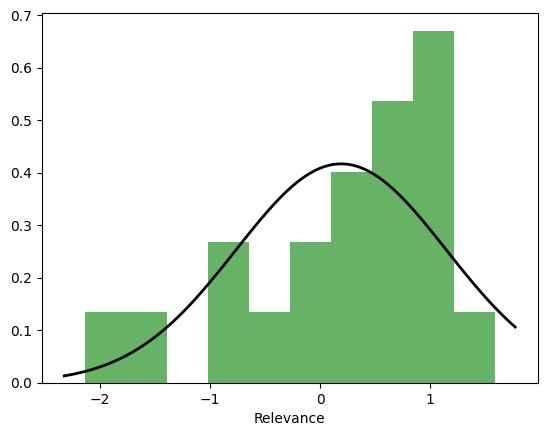

Follows normal distribution (Shapiro-Wilk)
Follows normal distribution (Kolmogorov-Smirnov)
Precision@10: 0.6
Recall@10: 0.42857142857142855
[ 0.56523478 -1.73181086  1.12530839 -2.13994441  0.9179507   1.11432753
  0.69762023 -0.92859521  0.13468285 -0.06933258  0.32783184  0.91159028
  0.25457365  0.88341032  0.77241805  0.07776567 -0.92604517  0.69176084
 -0.42636339  1.58850854]
Reciprocal Rank: 1.0


In [ ]:
from scipy.stats import norm, shapiro, kstest
import matplotlib.pyplot as plt

def normal_distribution(index: int) -> float:
    return norm.rvs(loc=0, scale=1)

search_results = generate_and_distribute(normal_distribution)
ranking = Ranking(search_results)

print("Precision@10:", ranking.precision_k(10))
print("Recall@10:", ranking.recall_k(10))
print("Reciprocal Rank:", ranking.RR())

4.2. Cauchy distribution

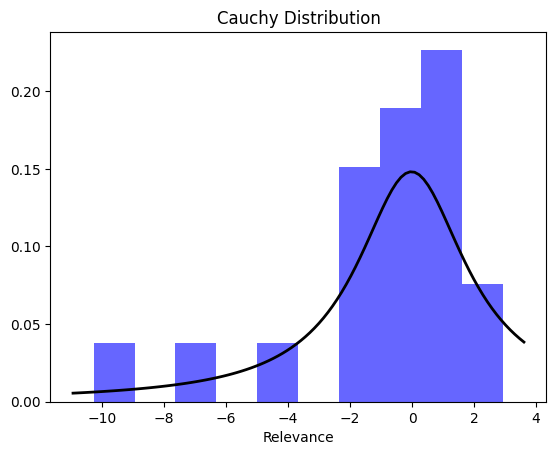

Data follows cauchy distribution (Kolmogorov-Smirnov)
Precision@10: 0.5
Recall@10: 0.5
[-7.18737614e+00  1.76270990e+00  2.95054596e+00  1.07209467e+00
 -1.04947019e+00  7.33828823e-03 -1.32491034e+00 -1.20230804e+00
  1.05849933e+00 -1.69516517e+00  5.30728544e-01 -4.93942017e-01
 -1.02836419e+01 -4.84147661e+00 -7.91343639e-01  1.29591691e+00
  1.48157637e-01  6.54929576e-01 -4.50705796e-02  8.68342399e-01]
Reciprocal Rank: 0.5


In [ ]:
from scipy.stats import cauchy

def cauchy_distribution(index: int) -> float:
    return cauchy.rvs(loc=0, scale=1)

search_results = generate_and_distribute(cauchy_distribution)
ranking = Ranking(search_results)

print("Precision@10:", ranking.precision_k(10))
print("Recall@10:", ranking.recall_k(10))
print("Reciprocal Rank:", ranking.RR())

4.3. Beta distribution

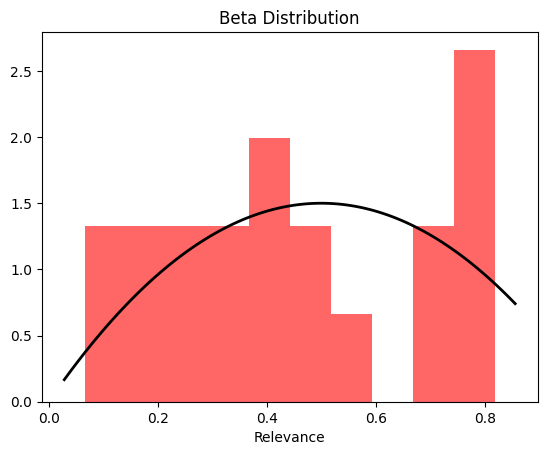

Data follows Beta distribution (Kolmogorov-Smirnov)
Data follows Beta distribution (Cramer von Mises)
Precision@10: 0.4
Recall@10: 0.5714285714285714
[-0.07740882 -0.24927963  0.81655257  0.69698488 -0.47649749 -0.39417648
 -0.16046078  0.76020178 -0.20165915  0.69129955 -0.06616668 -0.45381989
 -0.35437287 -0.36019878  0.52704017 -0.42237982 -0.23726237 -0.43394167
  0.81417221  0.81803908]
Reciprocal Rank: 0.3333333333333333


In [ ]:
from scipy.stats import beta
from scipy.stats import beta, kstest, anderson, cramervonmises

def beta_distribution(index: int) -> float:
    return beta.rvs(2.0, 2.0)

search_results = generate_and_distribute(beta_distribution)

for result in search_results:
  if result.relevance < 0.5:
    result.relevance *= -1
ranking = Ranking(search_results)

print("Precision@10:", ranking.precision_k(10))
print("Recall@10:", ranking.recall_k(10))
print("Reciprocal Rank:", ranking.RR())

All distributions show different results in metrics, as it depends on the pre-generated relevance, where random distributions are applied